In [21]:
# オリジナルモジュールのインポート
from lib.introngap import PileUp
from lib.gbkparse import Seq_count

# モジュールのインポート
import itertools
import logomaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [22]:
# 解析する塩基数を指定
n = 10

# XGBoostに関する変数の設定
early_stopping_rounds = 10
learning_rate = 0.01
max_depth = 8
x_random_state = 1
s_random_state =  0
test_size = 0.2

In [23]:
# クラスのインスタンス化
gbk = Seq_count()

# gbkファイルの読み込み
gbk.read_gbk('../data/gbk/human_ttn.gb')

# 各種バリアントの可視化
gbk.transcript_variants()

デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定


In [24]:
# バリアントのリストを作成 
var = gbk.get_mrna_ids()

# 特殊なバリアントを除外する
rm_list = ["XM_024453100.2","NM_133379.5", "XM_024453099.1", "NM_003319.4", "XM_017004823.1", "NM_133432.3", "NM_133437.4"]
for i in rm_list:
    var.remove(i)

In [25]:
# すべてのエクソンの配列をvalueとする辞書を作成
# エクソン番号は、バリアントに関わらず統一的なナンバリングにする

all_exon_list = []
for i in var:
    gbk.set_mrna_id(i)
    for j in gbk.exon_list():
        if j not in all_exon_list:
            all_exon_list.append(j)

all_exon_list.sort(key=lambda x: x[0])

exon_dic = {}
for i in range(len(all_exon_list)):
    exon_dic[i+1] = all_exon_list[i]

In [26]:
# 各バリンアントのおける統一的エクソンナンバーの組み合わせを作成
def get_key(value):
    for i in exon_dic.keys():
        if exon_dic[i] == value:
            return i

variant_dic = {}
for v in var:
    gbk.set_mrna_id(v)
    tmp_list = []
    for i in gbk.exon_list():
            tmp_list.append(get_key(i))
    variant_dic[v] = tmp_list


In [27]:
# 存在しうるエクソンの組み合わせを作成
exon_comb = []
for i in var:
    ls = variant_dic[i]
    for i in range(len(ls)-1):
        exon_comb.append((ls[i], ls[i+1]))
exon_comb = set(exon_comb)

In [28]:
# exon40からexon230までの範囲に解析を限定する
exon_comb_ltd = []
for i,j in exon_comb:
    if i >= 40 and j <= 230:
        exon_comb_ltd.append((i,j))

exisistent_comb = sorted(exon_comb_ltd)
print("exon_comb_ltdの要素数:", len(exisistent_comb))
# exon_comb_ltd

exon_comb_ltdの要素数: 222


In [29]:
#  特殊なスプライスを受けるエクソン
for i in exon_dic.keys():
    if i < len(exon_dic.keys())-1:
        if exon_dic[i][1] > exon_dic[i+1][0]:
            print(i)

9


In [30]:
# エクソンを一つ以上飛ばす組み合わせを作成
exon_distant_comb = []
for i,j in exisistent_comb:
    if j - i > 1:
        exon_distant_comb.append((i,j))
# exon_distant_comb

In [31]:
space_filling_comb = []
for i,j in exon_distant_comb:
    for k in range(j-i):
        space_filling_comb.append((i,i+k+1))

space_filling_comb = set(space_filling_comb)
# space_filling_comb

In [32]:
non_exisistent_comb = []
for i in space_filling_comb:
    if i not in exisistent_comb:
        non_exisistent_comb.append(i)
non_exisistent_comb = sorted(non_exisistent_comb)

In [33]:
# エクソンの組み合わせがあるイントロンの始点と終点のリスト
exisistent_comb_region = []
for i,j in exisistent_comb:
    exisistent_comb_region.append((exon_dic[i][1], exon_dic[j][0]))
# exisistent_comb_region

# エクソンの組み合わせが無いイントロンの始点と終点のリスト
non_exisistent_comb_region = []
for i,j in non_exisistent_comb:
    non_exisistent_comb_region.append((exon_dic[i][1], exon_dic[j][0]))
# non_exisistent_comb_region

In [34]:
# TTN遺伝子全長配列
seq = str(gbk.gDNA_seq())

In [35]:
# exisistent_comb_regionのイントロン両端のn塩基の配列を取得
exisistent_comb_region_edges = []
for i,j in exisistent_comb_region:
    left = seq[i:i+n]
    right = seq[j-n:j]
    exisistent_comb_region_edges.append((left+right))
exisistent_comb_region_edges

# non_exisistent_comb_regionのイントロン両端のn塩基の配列を取得
non_exisistent_comb_region_edges = []
for i,j in non_exisistent_comb_region:
    left = seq[i:i+n]
    right = seq[j-n:j]
    non_exisistent_comb_region_edges.append((left+right))
non_exisistent_comb_region_edges

['GTAAAGTAAAGATTATACAG',
 'GTAAGTAATTATTTTTAAAG',
 'GTACAGTGGCATCCTTTAAG',
 'GTACAGTGGCGTCTCTAAAG',
 'GTACAGTGGCTTTCTTAAAG',
 'GTACAGTGGCTCTTTTAAAG',
 'GTACAGTGGCTCTTTTCAAG',
 'GTACAGTGGCCTTTCTAAAG',
 'GTACAGTGGCATCTTTTAAG',
 'GTACAGTGGCATCTTTTAAG',
 'GTACAGTGGCCTCTTTAAAG',
 'GTAGGATTTGTCTTTTAAAG',
 'GTAGGATTTGGTCTTTAAAG',
 'GTAGGATTTGTCTTTTCAAG',
 'GTAGGATTTGCTTTCTAAAG',
 'GTAGGATTTGATCTTTTAAG',
 'GTAGGATTTGATCTTTTAAG',
 'GTAGGATTTGCTCTTTAAAG',
 'GTAGGATTTGTCCTTTAAAG',
 'GTATGATTTCATCTTTTAAG',
 'GTATGATTTCATCTTTTAAG',
 'GTATGATTTCCTCTTTAAAG',
 'GTAGAGTGAAATCTTTAAAG',
 'GTAGAGTGAAATATTTCAAG',
 'GTAGAGTGAAATCTTTAAAG',
 'GTAGAGTGAAATCTTTAAAG',
 'GTAGAGTGAAATCTTTAAAG',
 'GTACATTAATTGTTTTTAAG',
 'GTACATTAATGTCTTTAAAG',
 'GTACATTAATATTTTTAAAG',
 'GTATATCAAAATCTTTAAAG',
 'GTATATCAAAGCTCTTTCAG',
 'GTATATCAAAATCTTTGAAG',
 'GTATATCAAAATCTTTAAAG',
 'GTATATCAAAATCTTTAAAG',
 'GTATATCAAAATCTTTAAAG',
 'GTATATCAAAATCTTTTAAG',
 'GTATATCAAAATCTTTAAAG',
 'GTATATCAAAATCTTTAAAG',
 'GTATATCAAAATCTTTAAAG',


In [36]:
# ワンホットエンコーディングを行う関数
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    return np.array([mapping[s] for s in seq]).flatten()

# エンコーディングされた配列を準備
exisistent_comb_region_edges_arr = np.array([one_hot_encode(seq) for seq in exisistent_comb_region_edges])
non_exisistent_comb_region_edges_arr = np.array([one_hot_encode(seq) for seq in non_exisistent_comb_region_edges])

# 学習データとしてワンホとエンコーディングされた配列を結合しXとする
# ラベルをyとして結合する
X = pd.DataFrame(np.concatenate([exisistent_comb_region_edges_arr, non_exisistent_comb_region_edges_arr]))
y = pd.DataFrame(np.concatenate([np.ones(len(exisistent_comb_region_edges_arr)), np.zeros(len(non_exisistent_comb_region_edges_arr))]))

# XGBoostのインスタンス化
model = XGBClassifier(early_stopping_rounds=early_stopping_rounds, learning_rate=learning_rate, max_depth=max_depth, random_state=x_random_state)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=s_random_state)

# データをモデルにfitさせる
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

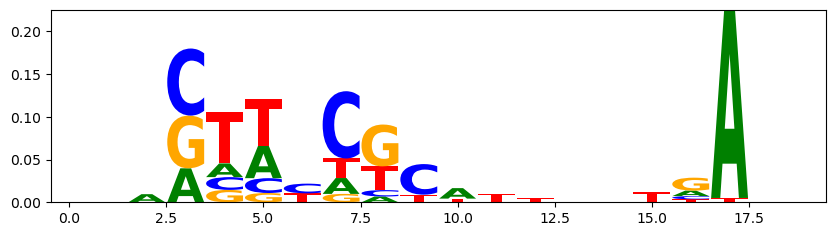

In [37]:
# logomakerを用いてモチーフを可視化
df = pd.DataFrame(model.feature_importances_.reshape(n*2,4))
df.columns = ['A','T','G','C']
crp_logo = logomaker.Logo(df, shade_below=.5, fade_below=.5)

Text(0.5, 1.0, 'non_exisistent_comb_region_edges')

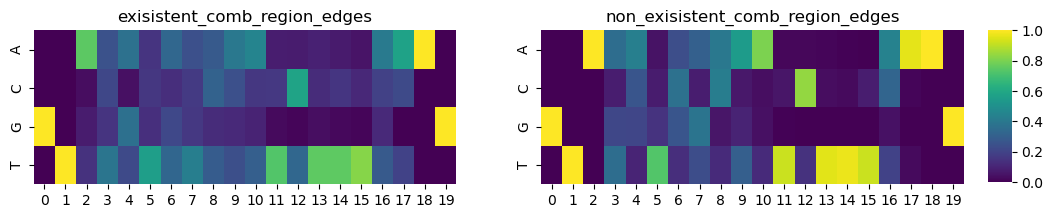

In [38]:
vmin, vmax = 0, 1

# ヒートマップの描画
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 2))

# 最初のヒートマップ
e_df = pd.DataFrame([list(i) for i in exisistent_comb_region_edges])
sns.heatmap(e_df.apply(pd.Series.value_counts).fillna(0).astype(int)/len(exisistent_comb_region_edges), ax=ax1, cmap="viridis", vmin=vmin, vmax=vmax, cbar=False)
ax1.set_title("exisistent_comb_region_edges")

# 2つ目のヒートマップ
n_df = pd.DataFrame([list(i) for i in non_exisistent_comb_region_edges])
cax = fig.add_axes([0.92, 0.12, 0.02, 0.76])  # カラーバーの位置とサイズを調整
sns.heatmap(n_df.apply(pd.Series.value_counts).fillna(0).astype(int)/len(non_exisistent_comb_region_edges), ax=ax2, cmap="viridis",vmin=vmin, vmax=vmax, cbar_ax=cax)
ax2.set_title("non_exisistent_comb_region_edges")

In [39]:
pos = 17
base = "A"

e_count = 0
for i in exisistent_comb_region_edges:
    if i[pos] == base:
        e_count += 1
print(e_count/len(exisistent_comb_region_edges))
        
n_count = 0
for i in non_exisistent_comb_region_edges:
    if i[pos] == base:
        n_count += 1
print(n_count/len(non_exisistent_comb_region_edges))


0.5765765765765766
0.9598214285714286
